# Visualizations for SAM
## Installing SAM
pip install git+https://github.com/facebookresearch/segment-anything.git

In [38]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

from segment_anything import sam_model_registry, SamPredictor
import segment_anything

In [5]:
import sys
sys.path.insert(0, './benchmarking/')
import datasets
import get_data

In [2]:
sam_checkpoint = "../../SAM/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

In [3]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [48]:
data_root = None
masks_path = '/Users/rodri/Library/CloudStorage/GoogleDrive-aavelarm@caltech.edu/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_same_size_as_input/'
inputs_path = '/Users/rodri/Library/CloudStorage/GoogleDrive-aavelarm@caltech.edu/My Drive/SURF_2023/Data/BigNeuron/'
custom_dataset = 'vaa3d'
transforms = ['bilinear']
data_len = 89
batch_size = 1
num_workers = 1
seed = 0
ratios = [1.0, 0.0, 0.0]
image_shape = [128, 256, 256]

dataset, _ , _, _ , _, _ = get_data.CreateDataset(ratios, image_shape, data_root, masks_path, inputs_path, custom_dataset, transforms, data_len, batch_size, num_workers, seed)

In [49]:
dataset[0][0].shape

torch.Size([1, 128, 256, 256])

In [50]:
# define original image size
original_image_size = image_shape[1:]

In [62]:
def get_image_slice(image, i):
    image_slice = image[0, i]
    image_slice = np.array(F.rgb_to_grayscale(F.to_pil_image(image_slice.unsqueeze(-1).numpy()), 3))
    return image_slice

In [57]:
def get_mask_slice(mask, i):
    # mask shape is expected to be 1x256x256
    mask_slice = mask[:, i]
    mask_slice = F.resize(mask_slice, [256, 256], antialias=True)
    return mask_slice

In [76]:
def plot_slice_prediction(image, mask, sam_pred, suptitle):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))
    fig.suptitle(suptitle)
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[1].imshow(mask[0], cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(sam_pred[0], cmap='gray')
    axs[2].set_title("SAM Prediction")

    plt.show()

In [70]:
def predict_3d_image(dataset, i, slice_start, slice_end, include_mask=True):
    """
    Predicts and plots masks using SAM

    Parameters:
    dataset: a torch dataset to pull data from
    i: the index of the input to use from the dataset
    slice_start: the index of the first slice to predict (inclusive)
    slice_end: the index of the last slice to predict (exclusive)
    """
    image, mask = dataset[i]

    for j in range(slice_start, slice_end):
        image_slice = get_image_slice(image, j)
        mask_slice = get_mask_slice(mask, j)

        predictor.set_image(image_slice)
        masks, _, _ = predictor.predict(
            mask_input = mask_slice if include_mask else None,
            multimask_output=False
        )

        plot_slice_prediction(image_slice, mask_slice, masks, j)

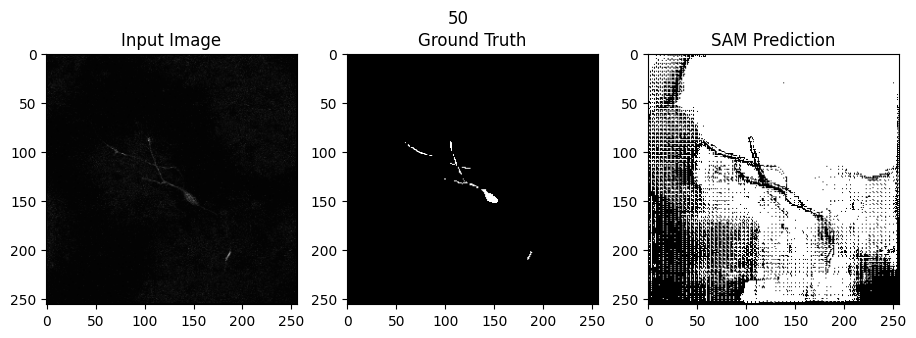

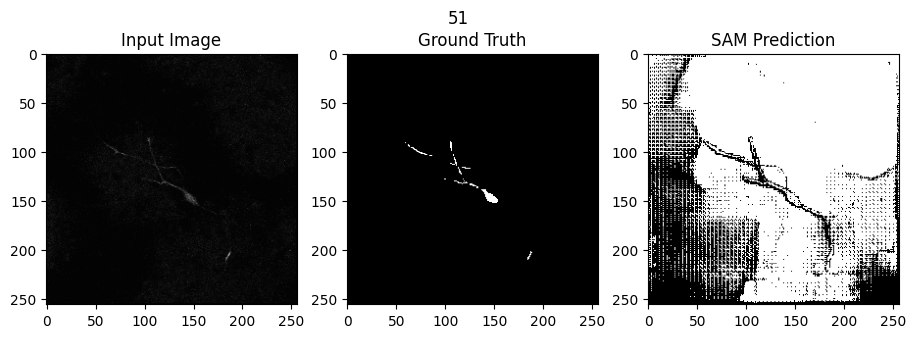

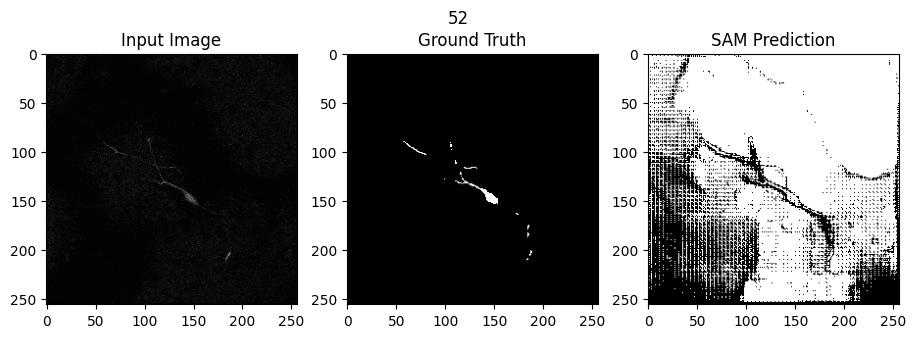

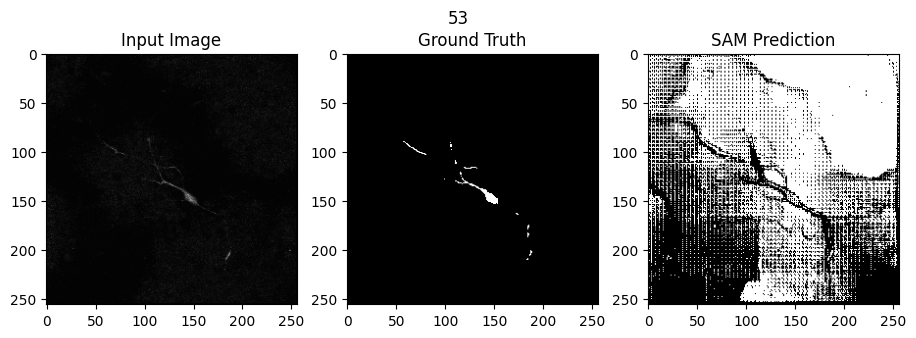

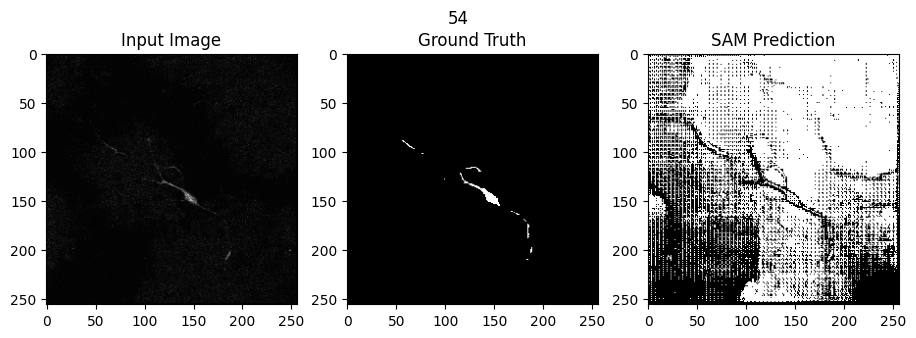

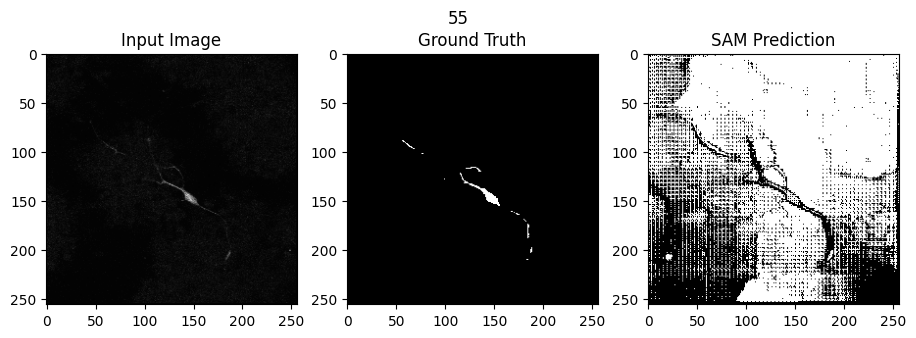

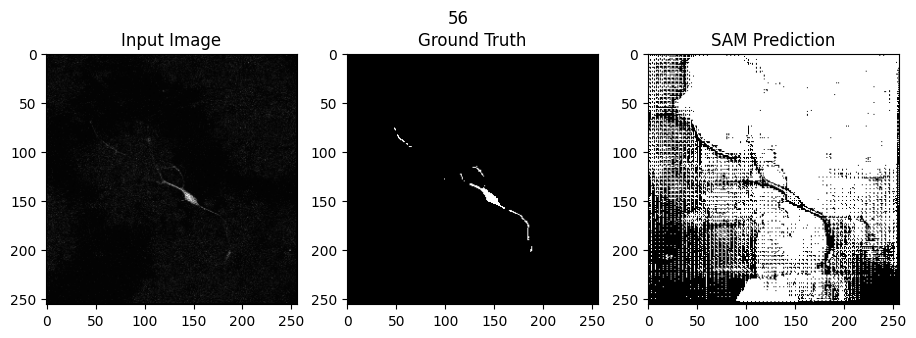

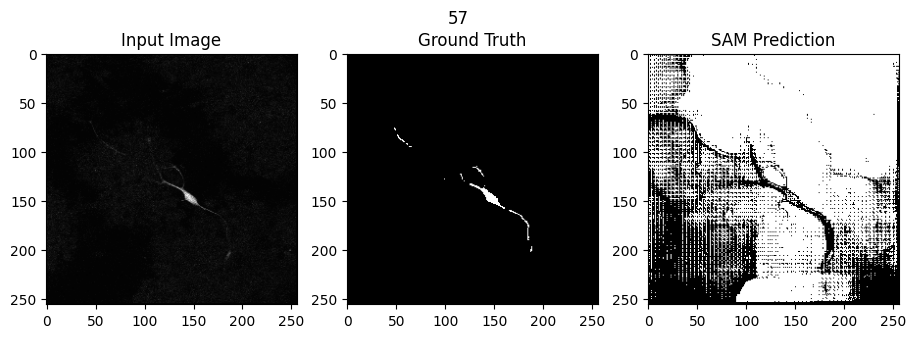

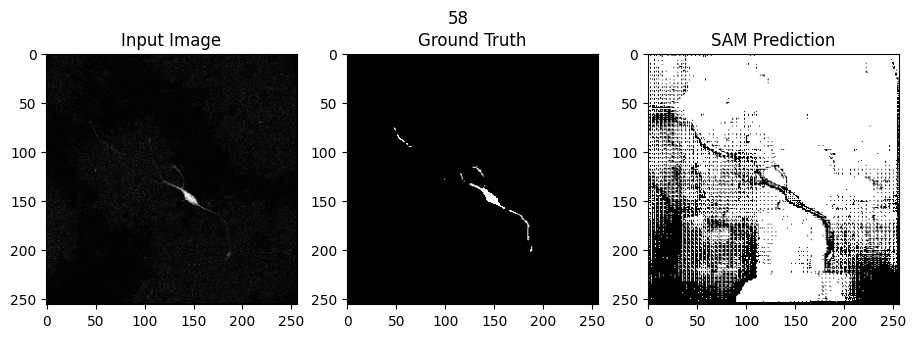

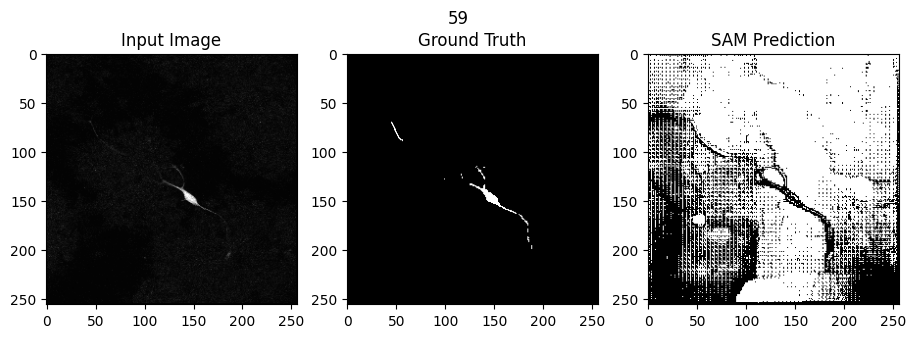

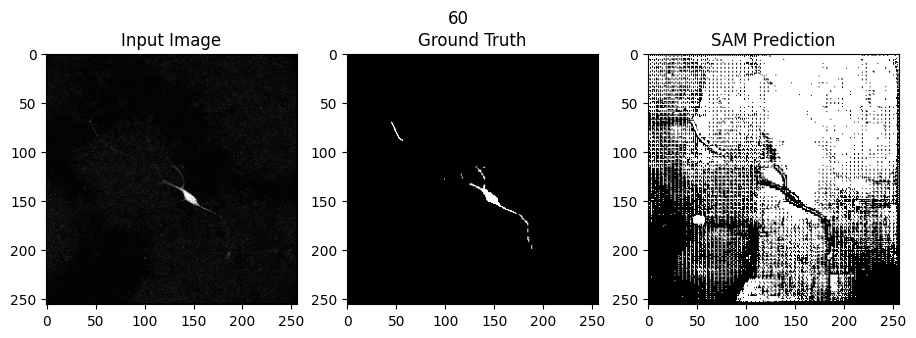

In [77]:
predict_3d_image(dataset, 10, 50, 61)

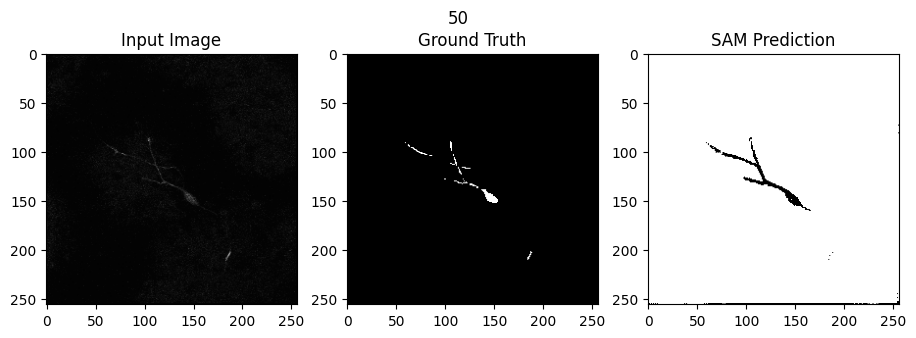

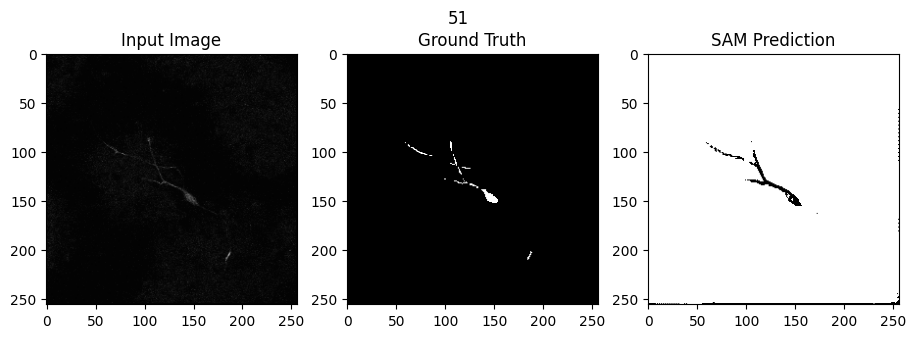

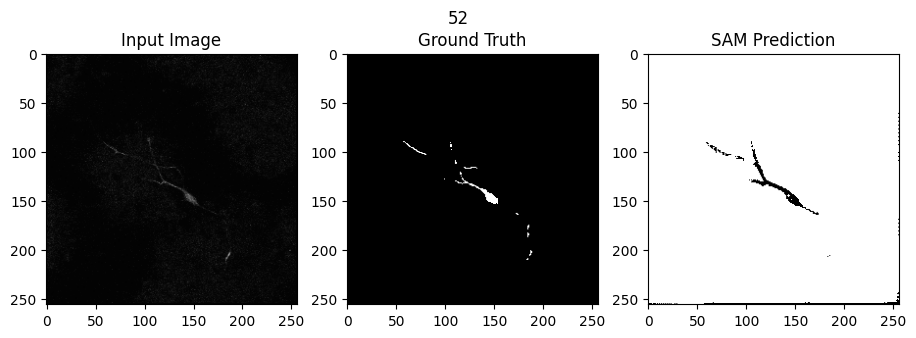

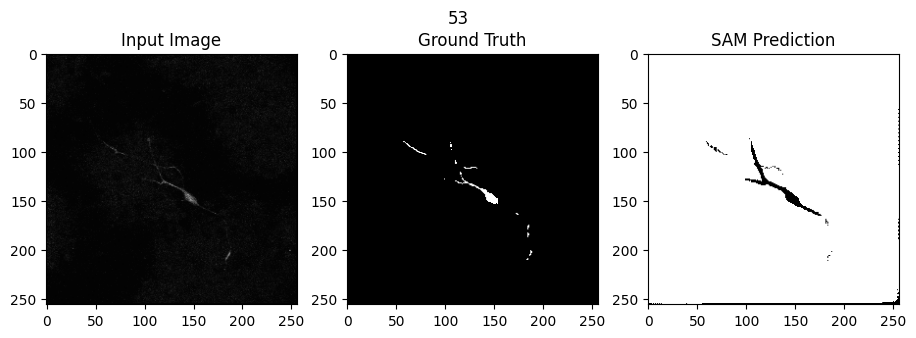

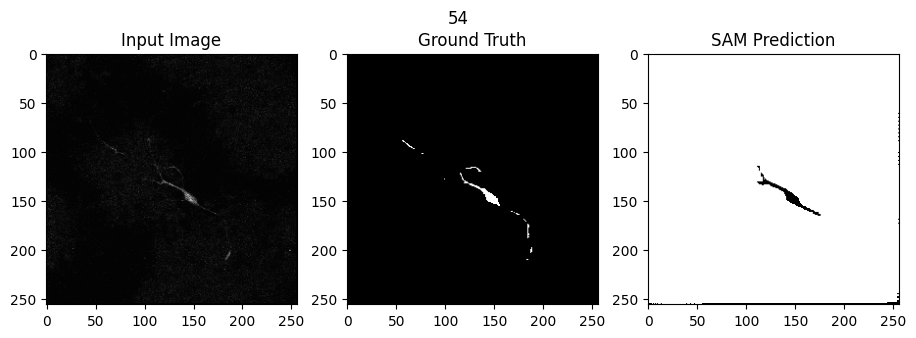

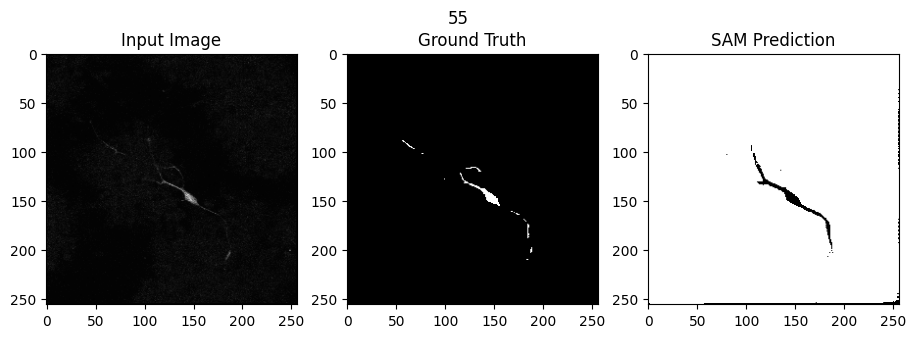

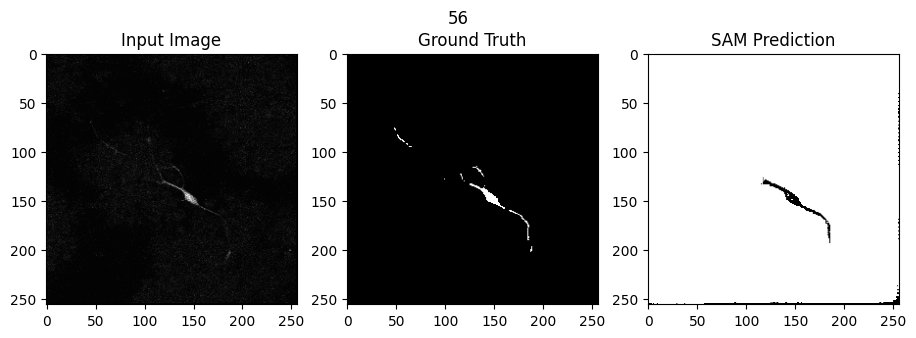

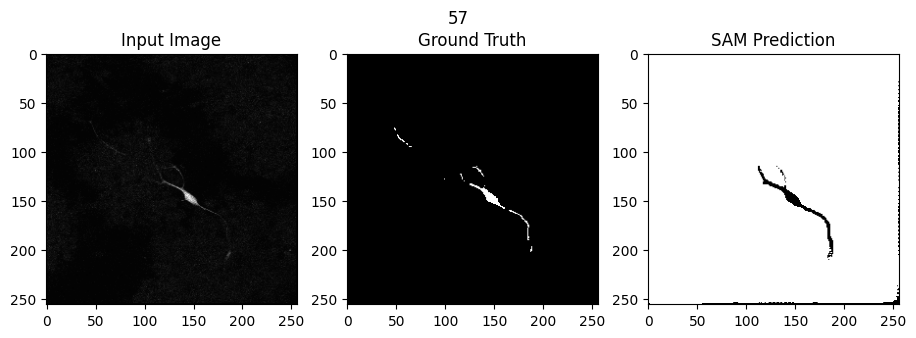

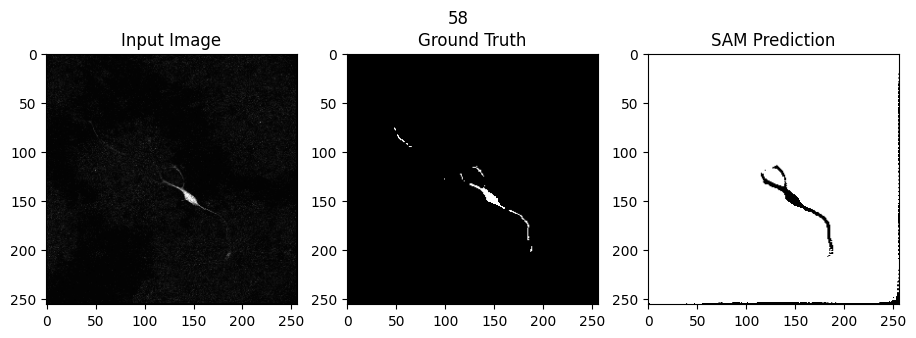

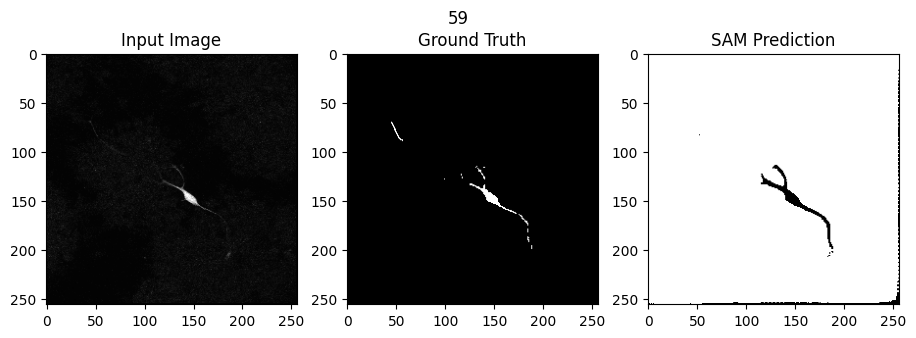

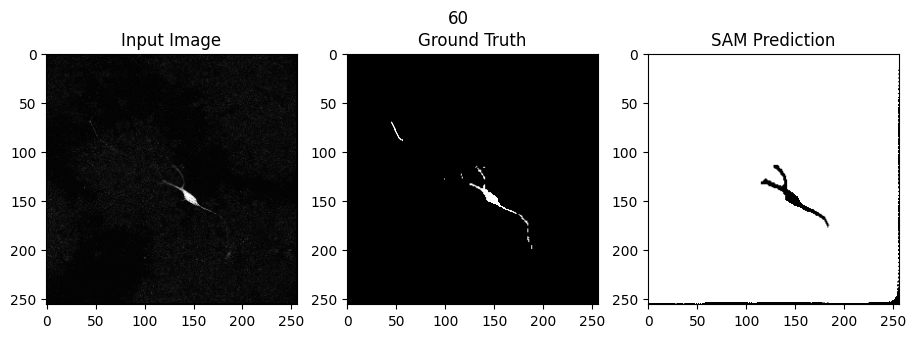

In [78]:
# see how mask input affects it
predict_3d_image(dataset, 10, 50, 61, False)